In [45]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

In [47]:
# import os
# import hashlib

# def remove_exact_duplicates(folder_path):
#     seen = set()
#     removed = 0

#     for subdir, _, files in os.walk(folder_path):
#         for file in files:
#             path = os.path.join(subdir, file)
#             try:
#                 with open(path, 'rb') as f:
#                     file_hash = hashlib.md5(f.read()).hexdigest()
#                 if file_hash in seen:
#                     os.remove(path)
#                     removed += 1
#                 else:
#                     seen.add(file_hash)
#             except Exception as e:
#                 print(f"Error processing {path}: {e}")

#     print(f"Removed {removed} exact duplicate image(s).")

# # Run this on your dataset
# remove_exact_duplicates("helmet_dataset")


In [49]:
# --- SETTINGS ---
dataset_path = "helmet_dataset"
batch_size = 8
image_size = 224
epochs = 8
lr = 0.001
print(os.listdir("helmet_dataset"))


['.DS_Store', 'not_looking', 'looking']


In [51]:
# --- DEVICE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [53]:
# --- SAFETY LOADER ---
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [55]:
# --- TRANSFORM ---
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

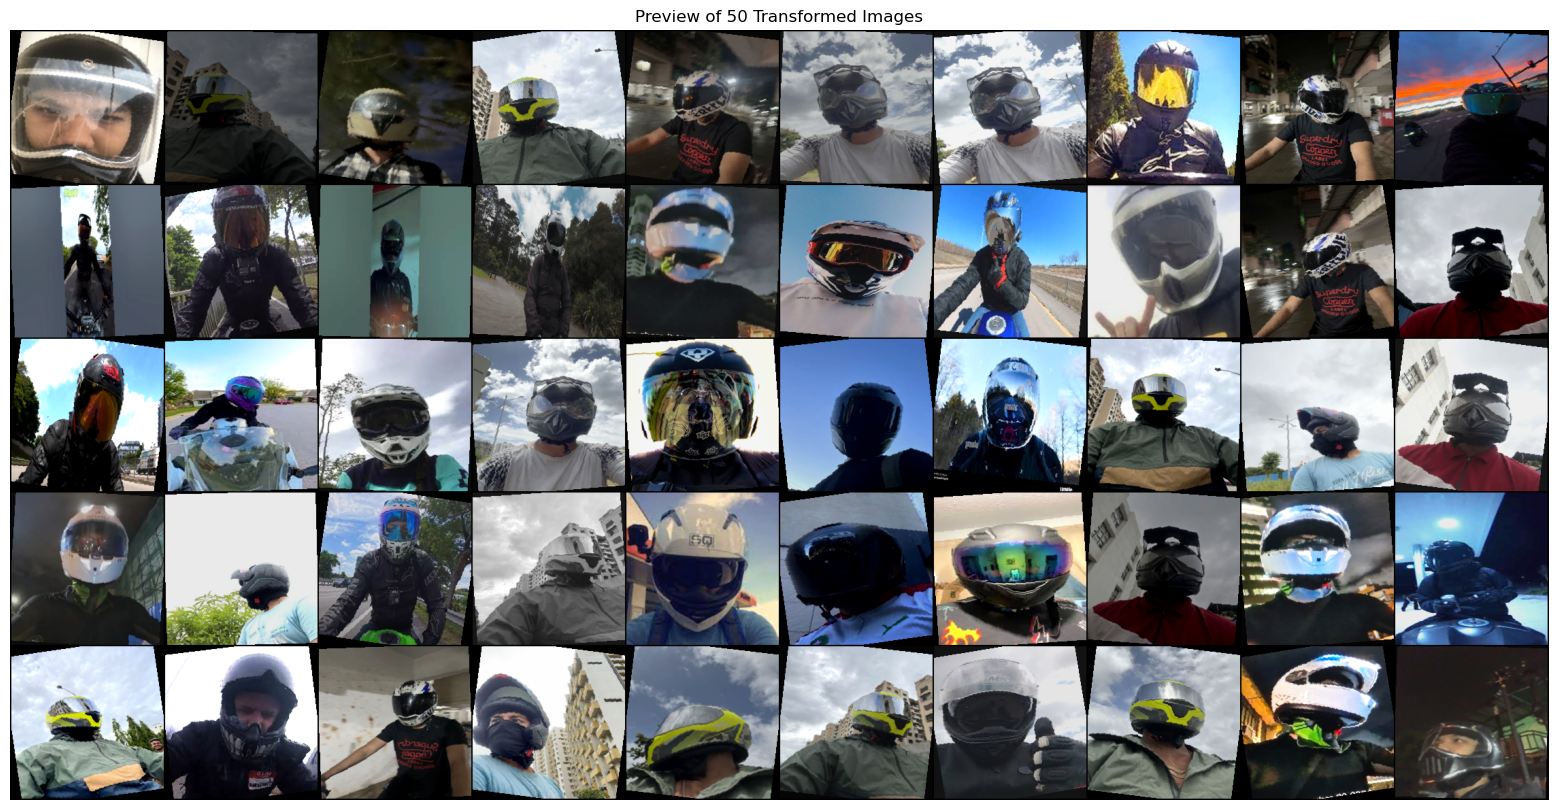

In [85]:
import torchvision

# Load dataset with transform applied
preview_dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=transform,
    loader=pil_loader
)

# Create a DataLoader (no shuffling)
preview_loader = DataLoader(preview_dataset, batch_size=50, shuffle=True)

# Get one batch
images, labels = next(iter(preview_loader))

# Make a grid of 50 images (5 rows × 10 columns)
grid_img = torchvision.utils.make_grid(images[:50], nrow=10, padding=2)

# Unnormalize if needed (for display only)
np_img = grid_img.permute(1, 2, 0).numpy()

# Show the image grid
plt.figure(figsize=(20, 10))
plt.imshow(np_img)
plt.axis('off')
plt.title("Preview of 50 Transformed Images")
plt.show()

In [57]:
import shutil

# Delete any .ipynb_checkpoints inside helmet_dataset
checkpoints_path = os.path.join(dataset_path, ".ipynb_checkpoints")
if os.path.exists(checkpoints_path):
    shutil.rmtree(checkpoints_path)
    print("Removed .ipynb_checkpoints folder.")

In [59]:
# --- DATASET ---
def is_valid_image(path):
    return not any(x in path for x in ['.DS_Store', '.ipynb_checkpoints'])
    
dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=transform,
    loader=pil_loader,
    is_valid_file=is_valid_image
)
print("Classes:", dataset.classes)
print("Class-to-index:", dataset.class_to_idx)

Classes: ['looking', 'not_looking']
Class-to-index: {'looking': 0, 'not_looking': 1}


In [61]:
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

# Use full dataset (700 images)
targets = dataset.targets  # From ImageFolder

# Change test_size here: 0.2 = 80/20, 0.3 = 70/30
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

# Optional: Verify class balance
print("Train set size:", len(train_dataset))
print("Val set size:", len(val_dataset))

train_labels = [dataset.targets[i] for i in train_dataset.indices]
val_labels = [dataset.targets[i] for i in val_dataset.indices]
print("Train class counts:", Counter(train_labels))
print("Val class counts:", Counter(val_labels))

Train set size: 560
Val set size: 140
Train class counts: Counter({0: 282, 1: 278})
Val class counts: Counter({0: 70, 1: 70})


In [63]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [65]:
# --- MODEL ---
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

NameError: name 'resnet50' is not defined

In [67]:
# --- LOSS & OPTIMIZER ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [69]:
# --- METRICS TRACKING ---
train_losses = []
val_accuracies = []

In [71]:
# --- TRAINING LOOP ---
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # --- VALIDATION ---
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Val Accuracy: {accuracy:.2f}%")

Epoch 1/8 - Loss: 0.4825 - Val Accuracy: 80.00%
Epoch 2/8 - Loss: 0.3129 - Val Accuracy: 64.29%
Epoch 3/8 - Loss: 0.3988 - Val Accuracy: 80.00%
Epoch 4/8 - Loss: 0.3698 - Val Accuracy: 79.29%
Epoch 5/8 - Loss: 0.3043 - Val Accuracy: 81.43%
Epoch 6/8 - Loss: 0.2176 - Val Accuracy: 81.43%
Epoch 7/8 - Loss: 0.3156 - Val Accuracy: 81.43%
Epoch 8/8 - Loss: 0.2748 - Val Accuracy: 80.00%


In [73]:
# --- FINAL REPORT ---
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


Classification Report:
              precision    recall  f1-score   support

     looking       0.83      0.76      0.79        70
 not_looking       0.78      0.84      0.81        70

    accuracy                           0.80       140
   macro avg       0.80      0.80      0.80       140
weighted avg       0.80      0.80      0.80       140



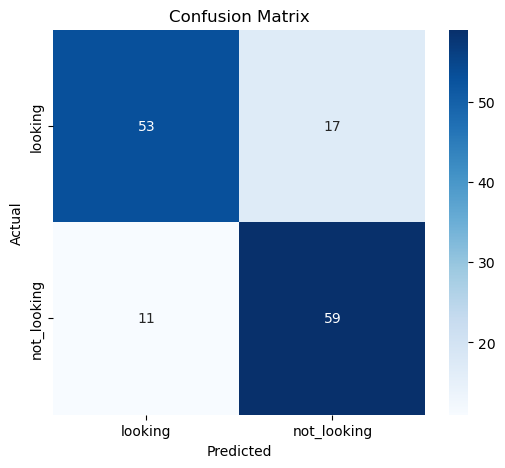

In [75]:
# --- CONFUSION MATRIX ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

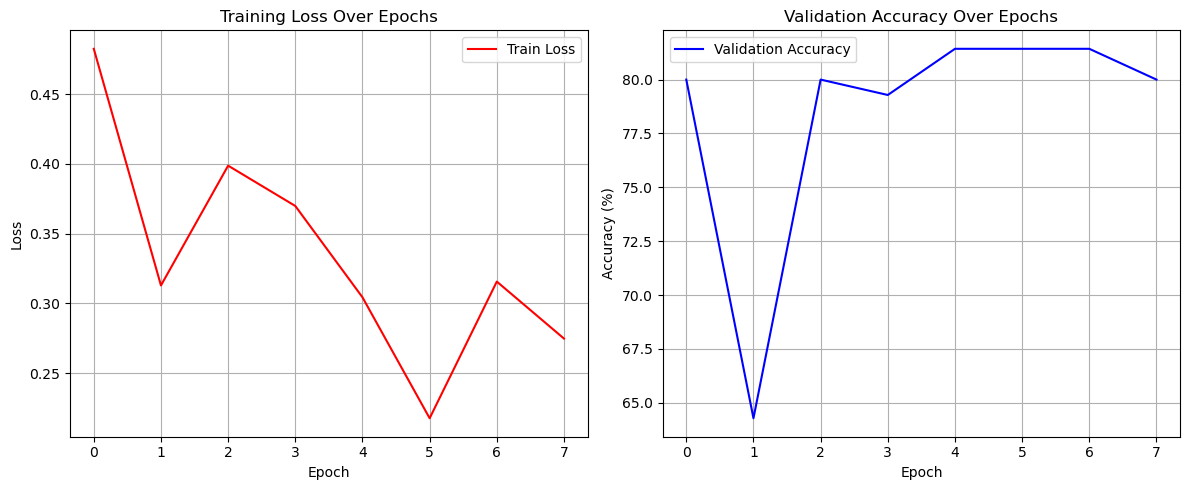

In [77]:
# --- PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='red')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='blue')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()